In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LM:

    def __init__(self, path, d):
        with open(path) as f:
            dct = json.load(f)
        self.n = dct['n']
        self.eos = dct['eos']
        self.c_abc = dct['c_abc']
        self.c_abx = dct['c_abx']
        self.u_abx = dct['u_abx']
        self.u_xbc = dct['u_xbc']
        self.u_xbx = dct['u_xbx']
        self.r_xbx = dct['r_xbx']
        self.vocab = dct['vocab']
        self.d = d

    def predict_lower(self, ngram):
        if len(ngram) == 0:
            return 1 / len(self.vocab)

        abc, ab = '|'.join(ngram), '|'.join(ngram[:-1])

        if (abc in self.u_xbc) and (ab in self.u_xbx):
            alpha = (self.u_xbc[abc] - self.d) / self.u_xbx[ab]
        else:
            alpha = 0

        if ab in self.u_xbx:
            gamma = self.d * self.r_xbx[ab] / self.u_xbx[ab]
        else:
            gamma = 1

        return alpha + gamma * self.predict_lower(ngram[1:])

    def predict(self, ngram):
        abc, ab = '|'.join(ngram), '|'.join(ngram[:-1])

        if (abc in self.c_abc) and (ab in self.c_abx):
            alpha = (self.c_abc[abc] - self.d) / self.c_abx[ab]
        else:
            alpha = 0

        if ab in self.c_abx:
            gamma = self.d * self.u_abx[ab] / self.c_abx[ab]
        else:
            gamma = 1

        return alpha + gamma * self.predict_lower(ngram[1:])

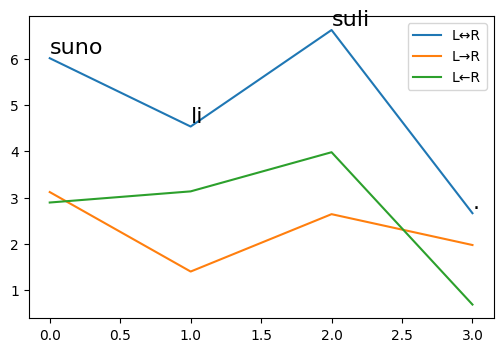

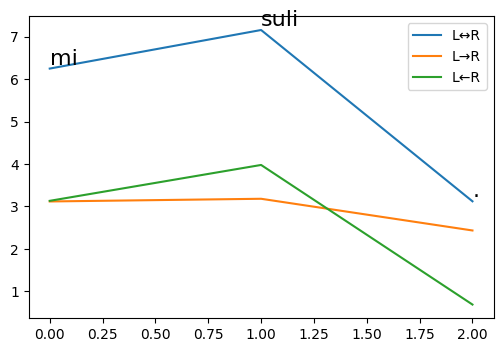

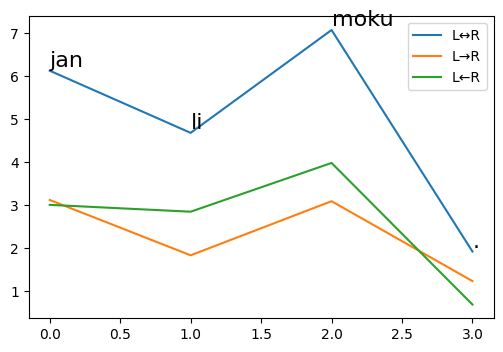

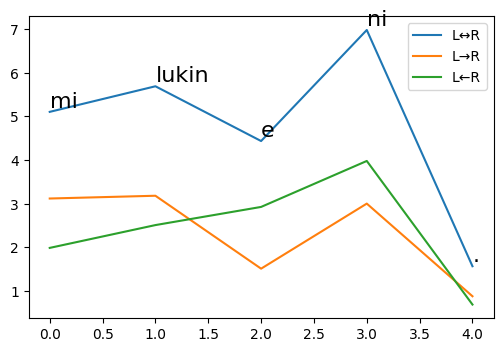

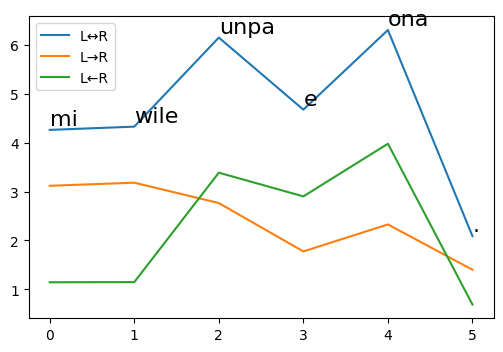

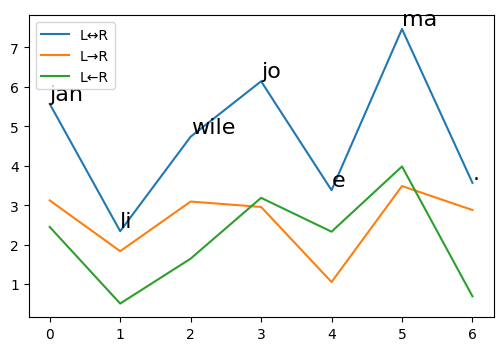

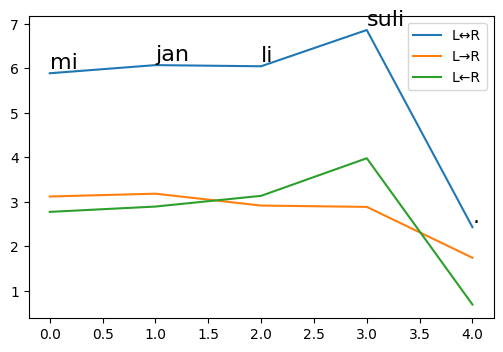

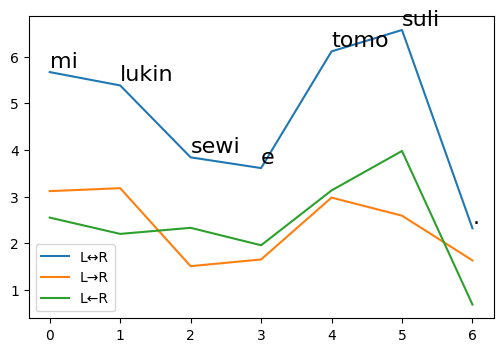

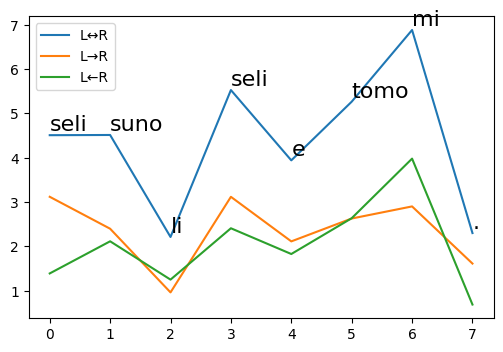

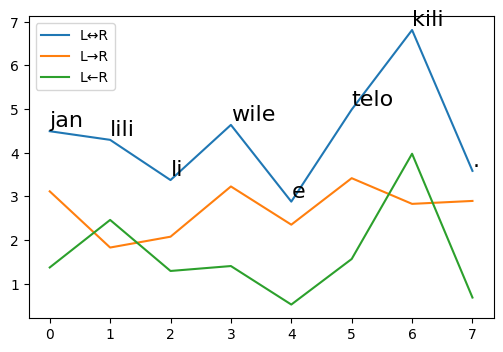

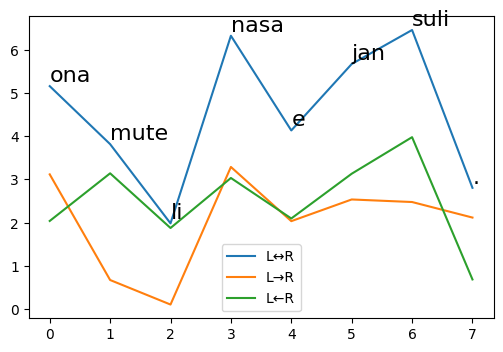

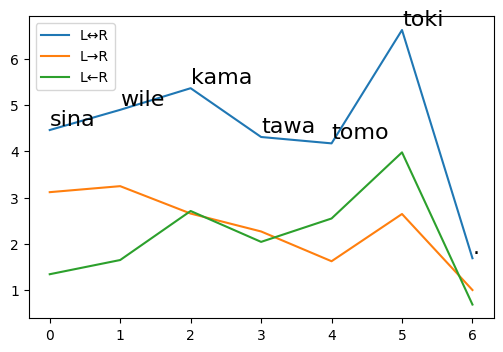

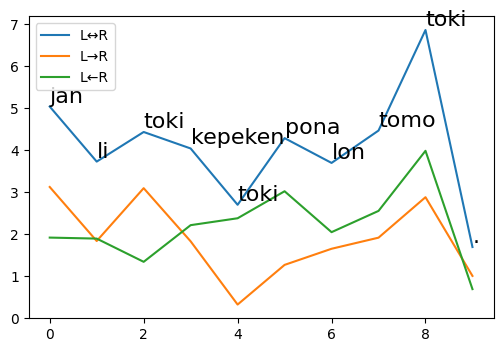

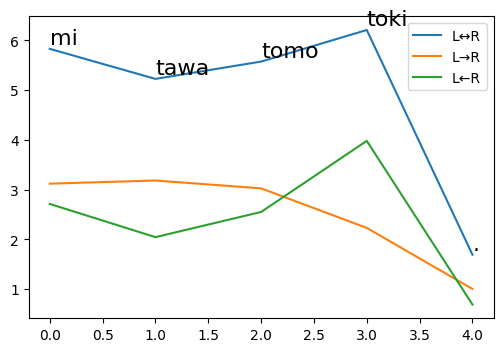

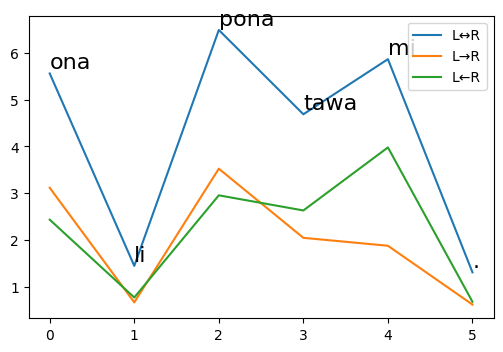

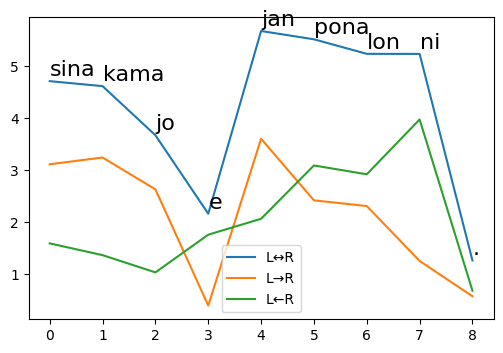

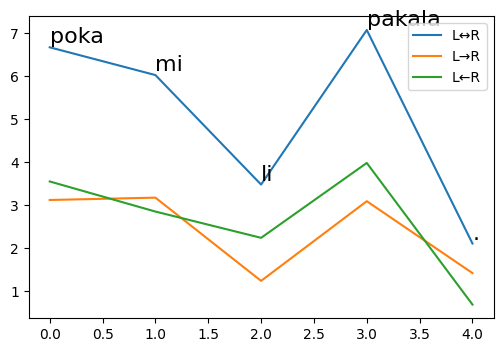

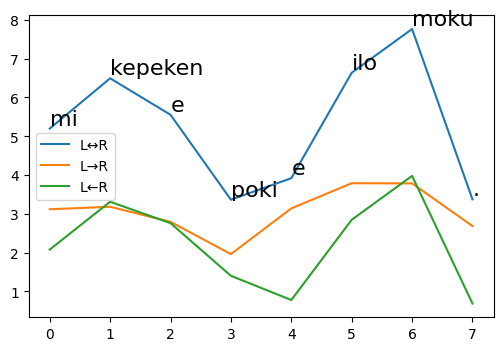

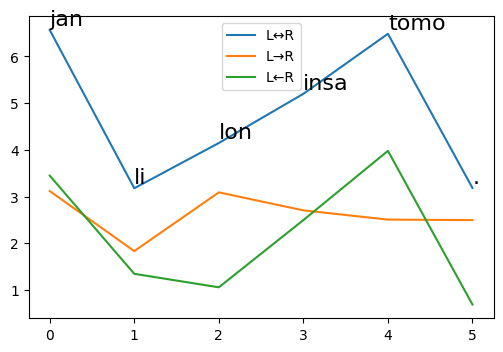

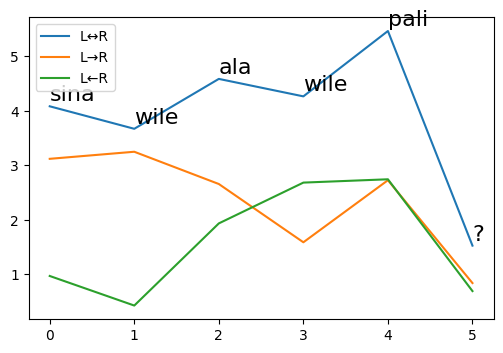

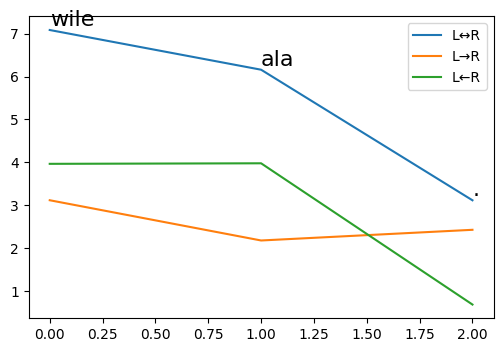

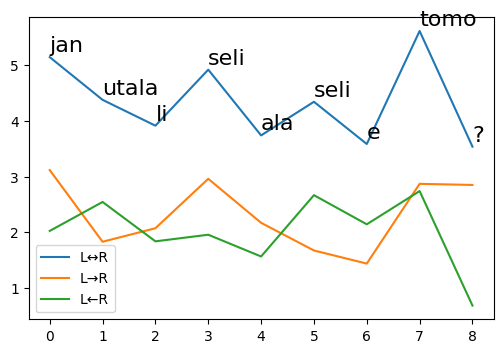

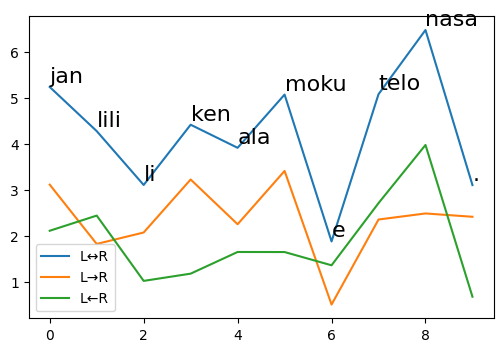

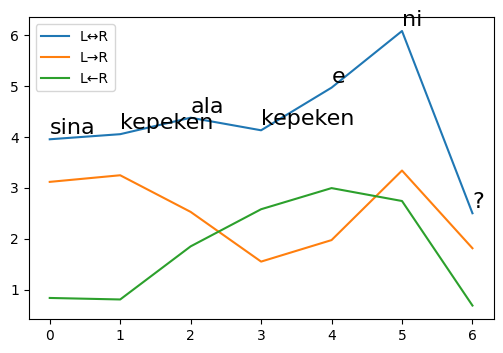

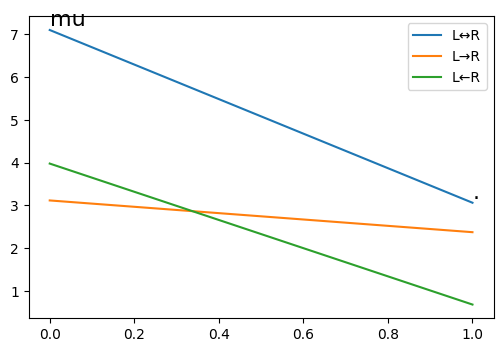

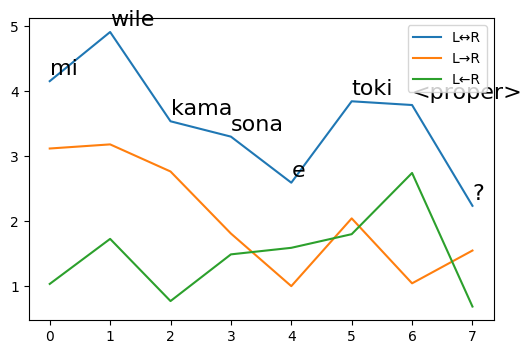

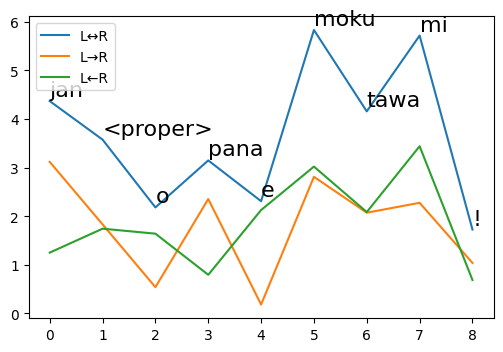

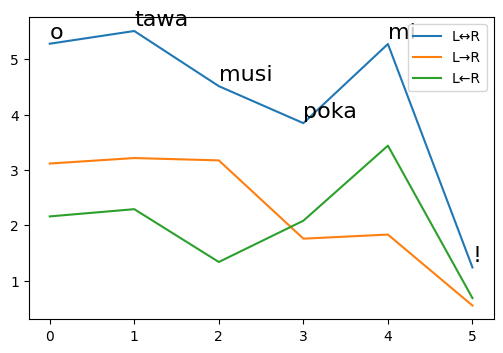

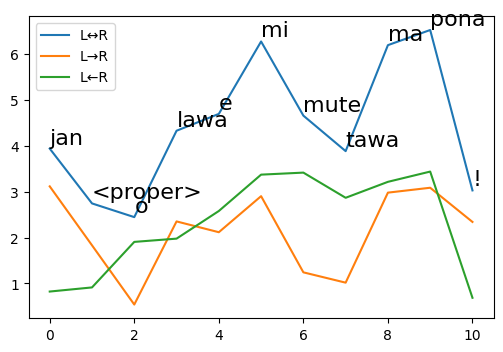

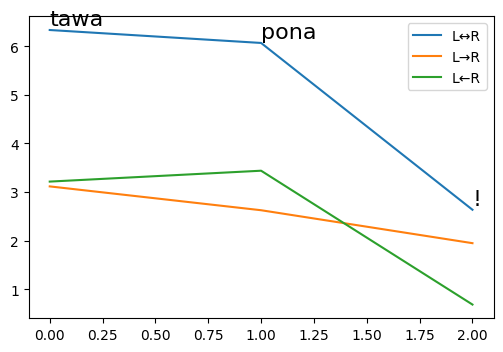

In [3]:
with open('valid.txt') as f:
    data = [line.strip().split() for line in f]

lml = LM('lm.json', d = 0.75)
lmr = LM('lm.rev.json', d = 0.75)

def entropy(lm, ngram):
    probs = np.array([lm.predict(list(ngram) + [token]) for token in lm.vocab])
    probs = probs / probs.sum()
    ents = [p * np.log(p) for p in probs]
    return -np.sum(ents)

for sent in data[:30]:
    cappedl = ['<s>'] * 4 + sent
    cappedr = ['<s>'] * 4 + sent[::-1]
    
    ngram_listl = list(zip(*[cappedl[i:] for i in range(4)]))
    ngram_listr = list(zip(*[cappedr[i:] for i in range(4)]))
    
    entsl = [entropy(lml, ngram) for ngram in ngram_listl][:-1]
    entsr = [entropy(lmr, ngram) for ngram in ngram_listr][:-1][::-1]
    ents = [l + r for l, r in zip(entsl, entsr)]
    
    plt.figure(dpi=100)
    plt.plot(ents)
    plt.plot(entsl)
    plt.plot(entsr)
    plt.legend(['L↔R', 'L→R', 'L←R'])
    for index, (ent, token) in enumerate(zip(ents, sent)):
        plt.annotate(token, (index, ent + 0.1), size=16)
    plt.show()